# 02 – Model Development
### Student Depression Prediction: Building and Evaluating the XGBoost Classifier

---

## 📌 Objective  
Develop an end-to-end XGBoost classification pipeline to predict student depression using the preprocessed dataset.

**Key Tasks:**

 **Model Pipeline**  
- Train-test split  
- Categorical encoding

 **XGBoost Implementation**  
- Baseline model  
- Hyperparameter tuning  
- Cross-validation  

 **Model Evaluation**  
- Performance metrics (accuracy, precision, recall, F1, ROC-AUC)  
- Feature importance analysis  

---

### 📂 Input  
 - `clean_data.csv` saved in `Data/processed/FC110552_mithula-cbw/` (preprocessed dataset)


### 📦 Output  
- `xgb_model.pkl` saved in `models/FC110552_mithula-cbw/`

---

### 📈 Expected Outcomes
- Trained and validated XGBoost classification model for student depression prediction
- Performance evaluation metrics (accuracy, precision, recall, F1-score, ROC-AUC)
- Insights from feature importance analysis
- Model artifacts saved for future inference and deployment


## Step 1: Import Libraries & Load Data

In [30]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable

# Scikit-learn modules for model selection and evaluation
from sklearn.model_selection import train_test_split,  GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    roc_auc_score,
    make_scorer
)

# XGBoost classifier
import xgboost as xgb
from xgboost import XGBClassifier


### Load preprocessed data

In [31]:
# Load preprocessed data
df = pd.read_csv('Data/processed/FC110552_mithula-cbw/clean_data.csv')

print("\n🔹 DataFrame Dimensions")
print("------------------------")
print(f"   Rows   : {df.shape[0]}")
print(f"   Columns: {df.shape[1]}")


🔹 DataFrame Dimensions
------------------------
   Rows   : 27868
   Columns: 13


In [32]:
# Print the first few rows of the data set
print(f"\n🔹 First 5 rows:")
df.head(3)


🔹 First 5 rows:


,gender,age,academic_pressure,cgpa,study_satisfaction,dietary_habits,have_you_ever_had_suicidal_thoughts,work_study_hours,financial_stress,family_history_of_mental_illness,depression,degree_encoded,sleep_duration_encoded
0,Male,33.0,5.0,8.97,2.0,Healthy,Yes,3.0,1.0,No,1,2,1
1,Female,24.0,2.0,5.90,5.0,Moderate,No,3.0,2.0,Yes,0,2,1
2,Male,31.0,3.0,7.03,5.0,Healthy,No,9.0,1.0,Yes,0,2,0


In [33]:
# Print data structure and datatypes of each column
table = PrettyTable()
table.field_names = ["Column", "Non-Null Count", "Dtype"]

for col in df.columns:
    non_null_count = df[col].count()
    dtype = df[col].dtype
    table.add_row([col, non_null_count, dtype])

print("\n🔹 Dataset Summary:")
print(table)


🔹 Dataset Summary:
+-------------------------------------+----------------+---------+
|                Column               | Non-Null Count |  Dtype  |
+-------------------------------------+----------------+---------+
|                gender               |     27868      |  object |
|                 age                 |     27868      | float64 |
|          academic_pressure          |     27868      | float64 |
|                 cgpa                |     27868      | float64 |
|          study_satisfaction         |     27868      | float64 |
|            dietary_habits           |     27868      |  object |
| have_you_ever_had_suicidal_thoughts |     27868      |  object |
|           work_study_hours          |     27868      | float64 |
|           financial_stress          |     27868      | float64 |
|   family_history_of_mental_illness  |     27868      |  object |
|              depression             |     27868      |  int64  |
|            degree_encoded           |   

💡 **Observations:**  
- No `id` column – No need to drop any identifier column.
- There are four object columns – These need encoding after the train-test split.

## Step 2: Train-Test Split

In [34]:
# Separate features and target
X = df.drop(['depression'], axis=1)  # Remove target column
y = df['depression']

> 🧠 To split the dataframe, we use stratified sampling to maintain the same  
class proportions in both the training and test sets.

> 🧠 Let's use an 80-20 split, where 80% of data is for training and 20% for testing.


In [35]:
# Stratified split to maintain class balance (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Print sizes of train and test sets
print(f"Training set size: {X_train.shape}")
print(f"Test set size:     {X_test.shape}")

# print depression rates in each split to verify stratification
print(f"Training set depression rate: {y_train.mean():.3f}")
print(f"Test set depression rate:     {y_test.mean():.3f}")

Training set size: (22294, 12)
Test set size:     (5574, 12)
Training set depression rate: 0.586
Test set depression rate:     0.586


💡 **Observations:**  
- The depression rate is consistent (58.6%) in both training and test sets.

> *🧠 confirming successful stratification and preserving class distribution for unbiased model evaluation.*

## Step 3: Categorical Encoding

> *🧠 Categorical columns (`gender`, `dietary_habits`, `suicidal_thoughts`, `family_history`) should now be encoded since the data has been split.*

In [36]:
# Let's Identify categorical columns to encode
categorical_columns = [
    'gender', 
    'dietary_habits', 
    'family_history_of_mental_illness', 
    'have_you_ever_had_suicidal_thoughts'
]

for col in categorical_columns:
    df[col] = df[col].astype("category")

In [37]:
# Print unique values in each categorical column to inspect categories before encoding
for col in categorical_columns:
    print(f"🔹 Unique values in {col}: {df[col].unique()}")


🔹 Unique values in gender: ['Male', 'Female']
Categories (2, object): ['Female', 'Male']
🔹 Unique values in dietary_habits: ['Healthy', 'Moderate', 'Unhealthy']
Categories (3, object): ['Healthy', 'Moderate', 'Unhealthy']
🔹 Unique values in family_history_of_mental_illness: ['No', 'Yes']
Categories (2, object): ['No', 'Yes']
🔹 Unique values in have_you_ever_had_suicidal_thoughts: ['Yes', 'No']
Categories (2, object): ['No', 'Yes']


💡 **Observations:**  
- All categorical columns have a small, well-defined set of unique categories.

> *🧠 Since all categorical variables have limited distinct values,   
>label encoding is appropriate and straightforward.*

In [38]:
# Check for unseen categories before encoding
for col in categorical_columns:
    train_categories = set(X_train[col].unique())
    test_categories = set(X_test[col].unique())
    unseen = test_categories - train_categories
    if unseen:
        print(f"Warning: Unseen categories in test set for '{col}': {unseen}")


# Label encode categorical variables
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    X_train[col + '_encoded'] = le.fit_transform(X_train[col])
    X_test[col + '_encoded'] = le.transform(X_test[col])
    label_encoders[col] = le

X_train.drop(columns=categorical_columns, inplace=True)
X_test.drop(columns=categorical_columns, inplace=True)


In [39]:
print("Train data preview after encoding:")
X_train.head(3)

Train data preview after encoding:


,age,academic_pressure,cgpa,study_satisfaction,work_study_hours,financial_stress,degree_encoded,sleep_duration_encoded,gender_encoded,dietary_habits_encoded,family_history_of_mental_illness_encoded,have_you_ever_had_suicidal_thoughts_encoded
20912,18.0,5.0,6.42,3.0,7.0,5.0,1,2,0,2,0,1
4158,33.0,1.0,6.08,2.0,10.0,2.0,2,1,1,2,1,1
26933,23.0,2.0,8.59,5.0,12.0,4.0,2,0,1,1,0,1


In [40]:
print("\nTest data preview after encoding:")
X_test.head(3)



Test data preview after encoding:


,age,academic_pressure,cgpa,study_satisfaction,work_study_hours,financial_stress,degree_encoded,sleep_duration_encoded,gender_encoded,dietary_habits_encoded,family_history_of_mental_illness_encoded,have_you_ever_had_suicidal_thoughts_encoded
16297,20.0,3.0,8.95,4.0,6.0,4.0,1,2,1,0,1,0
23609,21.0,5.0,7.75,2.0,10.0,5.0,2,2,0,2,1,1
13498,27.0,3.0,7.27,4.0,2.0,3.0,0,0,1,2,0,1


💡 **Observations:**  
- Original categorical columns dropped.
- Encoded columns are numeric and ready for modeling.

## Step 4: XGBoost Baseline Model Training and Evaluation

### Initialize and Train Baseline Model

In [41]:
# Create baseline XGBoost model with default parameters
xgb_baseline = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)

# Fit the baseline model
xgb_baseline.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


### Make Predictions

In [42]:
# Training predictions
y_train_pred = xgb_baseline.predict(X_train)
y_train_pred_proba = xgb_baseline.predict_proba(X_train)[:, 1]

# Test predictions
y_test_pred = xgb_baseline.predict(X_test)
y_test_pred_proba = xgb_baseline.predict_proba(X_test)[:, 1]

### Evaluate Model Performance

In [43]:
# Calculate metrics
def evaluate_model(y_true, y_pred, y_pred_proba, set_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred_proba)
    
    print(f"\n🔹 {set_name} Set Performance:")
    print(f"   Accuracy:  {accuracy:.4f}")
    print(f"   Precision: {precision:.4f}")
    print(f"   Recall:    {recall:.4f}")
    print(f"   F1-Score:  {f1:.4f}")
    print(f"   AUC-ROC:   {auc:.4f}")
    
    return accuracy, precision, recall, f1, auc

# Evaluate on both sets
print("🎯 BASELINE MODEL PERFORMANCE:")
train_metrics = evaluate_model(y_train, y_train_pred, y_train_pred_proba, "Training")
test_metrics = evaluate_model(y_test, y_test_pred, y_test_pred_proba, "Test")

🎯 BASELINE MODEL PERFORMANCE:

🔹 Training Set Performance:
   Accuracy:  0.9129
   Precision: 0.9137
   Recall:    0.9400
   F1-Score:  0.9267
   AUC-ROC:   0.9717

🔹 Test Set Performance:
   Accuracy:  0.8437
   Precision: 0.8549
   Recall:    0.8830
   F1-Score:  0.8687
   AUC-ROC:   0.9139


💡 **Observations:**  
- High training performance indicates the model has learned well.
- Test performance is slightly lower, showing mild overfitting.
- Recall is strong on both sets, meaning few depressed cases are missed.
- Precision is good, so false positives are reasonably controlled.
- AUC-ROC above 0.9 on test set shows excellent discrimination ability.

### Visualize Results with Confusion Matrix

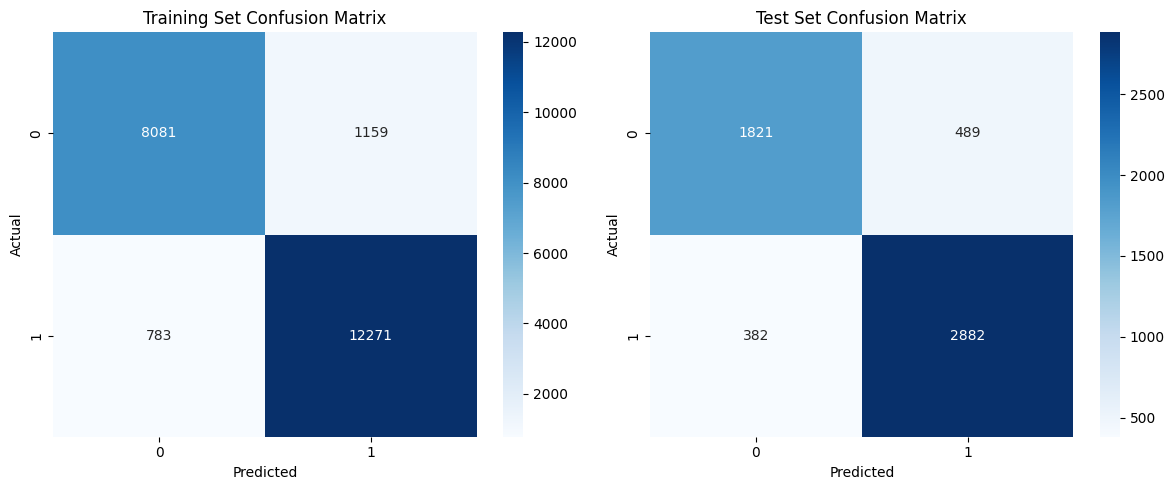

In [44]:
# Plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Training confusion matrix
cm_train = confusion_matrix(y_train, y_train_pred)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Training Set Confusion Matrix')
axes[0].set_ylabel('Actual')
axes[0].set_xlabel('Predicted')

# Test confusion matrix
cm_test = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Test Set Confusion Matrix')
axes[1].set_ylabel('Actual')
axes[1].set_xlabel('Predicted')

plt.tight_layout()
plt.show()

💡 **Observations:**  
- Again we notice training performs to be slightly better than test.
- More False Positives than False Negatives.

> *🧠 Model predicts "positive" too often.*

> *🎯 Next Actions:*
> - Tune hyperparameters to reduce overfitting.
> - Focus on regularization parameters.

# Step 5: Hyperparameter Tuning

**Current Situation Analysis**
- Training Accuracy ~91% | Test Accuracy: ~84% → Gap of 7% 
> *🧠 indicates overfitting.*
- Current Recall: ~88% 
> *🧠 ood but can improve*
- Current Precision ~85% 
> *🧠 decent, maintain while improving recall*
- Class Appears to be imbalanced.

## Tuning Phase 1: Regularization & Overfitting Control
> 🎯 Goal: Reduce the train-test performance gap to <3%

### Step 1.1: Basic Regularization Parameters

In [45]:
# Initial regularization-focused parameters
phase1_params = {
    'objective': 'binary:logistic',
    'eval_metric': ['auc', 'logloss'],
    'random_state': 42,
    
    # Regularization parameters
    'reg_alpha': 0.1,       
    'reg_lambda': 1.0,       
    'max_depth': 4,         
    'min_child_weight': 3,  
    'gamma': 0.1,           
    
    # Conservative learning
    'learning_rate': 0.05,   # Reduce from default 0.3
    'n_estimators': 200,     # Start conservative
    'subsample': 0.8,        # Row sampling
    'colsample_bytree': 0.8, # Column sampling
}

### Step 1.2: Grid Search for Regularization

In [50]:
# Grid search for regularization parameters
reg_param_grid = {
    'reg_alpha': [0.01, 0.1, 0.5, 1.0],
    'reg_lambda': [0.1, 1.0, 2.0, 5.0],
    'gamma': [0, 0.1, 0.2, 0.5],
    'min_child_weight': [1, 3, 5, 7]
}

total_combinations = 1
for v in reg_param_grid.values():
    total_combinations *= len(v)

print(f"Total combinations to test: {total_combinations}")

Total combinations to test: 256


In [51]:
recall_scorer = make_scorer(recall_score, pos_label=1)

grid_search_reg = GridSearchCV(
    XGBClassifier(**phase1_params),
    param_grid=reg_param_grid,
    scoring=recall_scorer,
    cv=5,
    n_jobs=-1,
    verbose=1
)

### Step 1.3: Fit grid search

In [52]:
# Fit grid search
print("🔄 Starting hyperparameter tuning...")
grid_search_reg.fit(X_train, y_train)

🔄 Starting hyperparameter tuning...
Fitting 5 folds for each of 256 candidates, totalling 1280 fits


,estimator,"XGBClassifier...ree=None, ...)"
,param_grid,"{'gamma': [0, 0.1, ...], 'min_child_weight': [1, 3, ...], 'reg_alpha': [0.01, 0.1, ...], 'reg_lambda': [0.1, 1.0, ...]}"
,scoring,"make_scorer(r..., pos_label=1)"
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'binary:logistic'


### Step 1.4: Select Optimal Parameter & Model

In [54]:
# Get the best hyperparameters and corresponding AUC score from GridSearchCV
best_phase1_params = grid_search_reg.best_params_
best_phase1_score = grid_search_reg.best_score_

# Print the best parameters found
print("🔹 Best Parameters:")
for param, value in best_phase1_params.items():
    print(f"  {param}: {value}")

# Print the best cross-validation AUC score achieved
print(f"\n🔹 Best Cross-Validation Recall Score: {best_phase1_score:.4f}")

🔹 Best Parameters:
  gamma: 0.2
  min_child_weight: 3
  reg_alpha: 0.5
  reg_lambda: 5.0

🔹 Best Cross-Validation Recall Score: 0.8855


In [56]:
# Get best model
reg_best_xgb = grid_search_reg.best_estimator_

### Step 1.5: Validate Tuned Model

In [58]:
# Make predictions with tuned model
y_train_pred_tuned = reg_best_xgb.predict(X_train)
y_train_pred_proba_tuned = reg_best_xgb.predict_proba(X_train)[:, 1]

y_test_pred_tuned = reg_best_xgb.predict(X_test)
y_test_pred_proba_tuned = reg_best_xgb.predict_proba(X_test)[:, 1]

# Evaluate tuned model
print("🎯 TUNED MODEL PERFORMANCE AFTER PHASE 1:")
train_metrics_tuned = evaluate_model(y_train, y_train_pred_tuned, y_train_pred_proba_tuned, "Training")
test_metrics_tuned = evaluate_model(y_test, y_test_pred_tuned, y_test_pred_proba_tuned, "Test")

🎯 TUNED MODEL PERFORMANCE AFTER PHASE 1:

🔹 Training Set Performance:
   Accuracy:  0.8553
   Precision: 0.8650
   Recall:    0.8921
   F1-Score:  0.8783
   AUC-ROC:   0.9290

🔹 Test Set Performance:
   Accuracy:  0.8524
   Precision: 0.8625
   Recall:    0.8897
   F1-Score:  0.8759
   AUC-ROC:   0.9234


💡 **Observations:**  
- Overfitting Gap: Reduced from ~7% to ~0.3% 
- Improved Test Metrics: All test evaluation metrics showed slight but consistent   
improvement compare to baseline model.

